In [1]:
import numpy as np
import os
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from datetime import datetime

print(tf.__version__)
print(tfk.__version__)

seed = int(datetime.now().timestamp())
np.random.seed(seed)
tf.random.set_seed(seed);


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import random

print("GPU available:", tf.config.list_physical_devices('GPU'))

2.16.1
3.3.3
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from math import log

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 16

# Learning rate: step size for updating the model's weights
# Notice that it can change dinamically later
learning_rate = 0.0001

# The percentage of the data set used for validation/testing
val_size = 0.15

# The patience value for early stopping
patience = 15

# Dropout rate
dropout_rate = 0.4

# l2 coefficient
l2_lambda = 0.001

# Depth of the VGG pre-trained model layer
depth = 2

# Number of neurons of the first dense layer (the others decay with base 2)
initial_neurons = 256

# To add the random crop to the train images
var_rand_eraser = True

trained_model = 'EfficientNet'
tm_version    = 'B2'

sizes = {
    'EfficientNetB0' : (224, 224),
    'EfficientNetB2' : (260, 260),
    'EfficientNetB4' : (380, 380),
    'VGG16'          : (224, 224),
    'DenseNet121'    : (224, 224),
    'ResNet50'       : (224, 224),
    'Xception'       : (299, 299),
    'ConvNeXtBase'   : (96, 96)
}

# Target size for the images
target_size = sizes[trained_model + tm_version]

assert epochs > 0
assert batch_size > 4 and log(batch_size, 2) == int(log(batch_size, 2))
assert learning_rate > 0
assert val_size > 0 and val_size < 0.25
assert patience > 0 and patience < 25
assert dropout_rate > 0 and dropout_rate <= 0.5
assert l2_lambda >= 0
assert depth >= 0 and depth < 16 # 0 for using the entire (VGG) model
assert target_size[0] > 0 and target_size[0] == target_size[1]
assert initial_neurons > 0 and log(initial_neurons, 2) == int(log(initial_neurons, 2))
assert isinstance(var_rand_eraser, bool)
assert trained_model + tm_version in sizes

# (Inactive) How to remove outliers from the dataset

In [3]:
"""# Before, run the parameters section

import numpy as np

# Carica il dataset originale
dataset_dir = '/kaggle/input/an2dl-hm1-correct-dataset/correct_training_set.npz'
data = np.load(dataset_dir)

# Assumiamo che il file contenga 'images' e 'labels' come chiavi
X = data['images']
y = data['labels'].ravel()

y_1 = y


# Prendi solo le prime 11.959 immagini e le relative etichette
X = images[:11959]
y = labels[:11959]

# Finding the unique images to avoid duplicates
_, unique_indices = np.unique(X.reshape(len(X), -1), axis=0, return_index=True)

# Select only those images
X = X[unique_indices]
y = y[unique_indices]

print(f"Sottoinsieme creato e salvato in {subset_path}")


from scipy.stats import chi2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Ellipse

# Appiattisci le immagini
X_flat = X.reshape(X.shape[0], -1)  # X ha shape (n_samples, 260, 260, 3)

# Opzionalmente riduci la dimensionalità con PCA
n_components = 2  # Seleziona un numero di componenti appropriato
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_flat)

# Calcola la media e la matrice di covarianza nei dati ridotti
mean = np.mean(X_reduced, axis=0)
cov_matrix = np.cov(X_reduced, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Funzione per calcolare la distanza di Mahalanobis
def mahalanobis_distance(x, mean, inv_cov_matrix):
    return np.sqrt((x - mean).T @ inv_cov_matrix @ (x - mean))

# Calcola le distanze di Mahalanobis per tutti i dati ridotti
distances = np.array([mahalanobis_distance(x, mean, inv_cov_matrix) for x in X_reduced])

# Soglia basata su distribuzione chi-quadro
alpha = 0.99  # livello di confidenza
threshold = np.sqrt(chi2.ppf(alpha, df=n_components))  # df = numero di componenti PCA

# Identifica gli outliers
outliers = distances > threshold

# Crea il grafico
fig, ax = plt.subplots(figsize=(12, 8))

# Funzione per sovrapporre immagini sui punti
def imscatter(x, y, image, ax=None, zoom=0.1):
    if ax is None:
        ax = plt.gca()
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

# Disegna i punti PCA con le immagini
for i, (x, y) in enumerate(X_reduced):
    img = X[i]  # Usa l'immagine originale
    imscatter(x, y, img, ax=ax, zoom=0.2)

# Disegna l'ellisse della covarianza
lambda_, v = np.linalg.eig(cov_matrix)
lambda_ = np.sqrt(lambda_)
ellipse = Ellipse(xy=mean,
                  width=lambda_[0] * 2 * np.sqrt(chi2.ppf(alpha, 2)),
                  height=lambda_[1] * 2 * np.sqrt(chi2.ppf(alpha, 2)),
                  edgecolor='green',
                  facecolor='none',
                  linestyle='--',
                  linewidth=2,
                  label="Covariance Ellipse")
ax.add_patch(ellipse)

# Evidenzia gli outliers
for i, (x, y) in enumerate(X_reduced[outliers]):
    ax.scatter(x, y, color='red', label="Outlier" if i == 0 else "", s=100, edgecolors='k')

# Etichette e legenda
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_title("PCA Outlier Detection with Images (Mahalanobis Distance)")
ax.legend()

plt.show()

plt.savefig("/kaggle/working/outliers.png")

# Rimuovi gli outliers
X_clean = X[~outliers]
y_clean = y_1[~outliers]

# Salva il sottoinsieme in un nuovo file .npz
subset_path = "/kaggle/working/correct_training_set2.npz"
np.savez(subset_path, images=X_clean, labels=y_clean)
"""

'# Before, run the parameters section\n\nimport numpy as np\n\n# Carica il dataset originale\ndataset_dir = \'/kaggle/input/an2dl-hm1-correct-dataset/correct_training_set.npz\'\ndata = np.load(dataset_dir)\n\n# Assumiamo che il file contenga \'images\' e \'labels\' come chiavi\nX = data[\'images\']\ny = data[\'labels\'].ravel()\n\ny_1 = y\n\n\n# Prendi solo le prime 11.959 immagini e le relative etichette\nX = images[:11959]\ny = labels[:11959]\n\n# Finding the unique images to avoid duplicates\n_, unique_indices = np.unique(X.reshape(len(X), -1), axis=0, return_index=True)\n\n# Select only those images\nX = X[unique_indices]\ny = y[unique_indices]\n\nprint(f"Sottoinsieme creato e salvato in {subset_path}")\n\n\nfrom scipy.stats import chi2\nfrom sklearn.decomposition import PCA\nfrom matplotlib import pyplot as plt\nfrom matplotlib.offsetbox import OffsetImage, AnnotationBbox\nfrom matplotlib.patches import Ellipse\n\n# Appiattisci le immagini\nX_flat = X.reshape(X.shape[0], -1)  # X 

# Augmentations with TensorFlow

In [4]:
def random_erasing(img, probability = 0.2, sl = 0.02, sh = 0.4, r1 = 0.3, method = 'black'):
    # Motivated by https://github.com/Amitayus/Random-Erasing-TensorFlow.git
    # Motivated by https://github.com/zhunzhong07/Random-Erasing/blob/master/transforms.py
    # Thanks to https://github.com/Janghyeonwoong/Random-Erasing-Tensorflow2/blob/master/erasing.py
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al. 
    -------------------------------------------------------------------------------------
    img : 3D Tensor data (H,W,Channels) normalized value [0,1]
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    method : 'black', 'white' or 'random'. Erasing type
    -------------------------------------------------------------------------------------
    '''
    assert method in ['random', 'white', 'black'], 'Wrong method parameter'

    if tf.random.uniform([]) > probability:
        return img

    img_width    = img.shape[1]
    img_height   = img.shape[0]
    img_channels = img.shape[2]

    area = img_height * img_width

    target_area = tf.random.uniform([],minval=sl, maxval=sh) * area
    aspect_ratio = tf.random.uniform([],minval=r1, maxval=1/r1)
    h = tf.cast(tf.math.round(tf.math.sqrt(target_area * aspect_ratio)), tf.int32)
    w = tf.cast(tf.math.round(tf.math.sqrt(target_area / aspect_ratio)), tf.int32)

    while tf.constant(True, dtype=tf.bool):
        if h > img_height or w > img_width:
            target_area = tf.random.uniform([],minval=sl, maxval=sh) * area
            aspect_ratio = tf.random.uniform([],minval=r1, maxval=1/r1)
            h = tf.cast(tf.math.round(tf.math.sqrt(target_area * aspect_ratio)), tf.int32)
            w = tf.cast(tf.math.round(tf.math.sqrt(target_area / aspect_ratio)), tf.int32)
        else:
            break

    x1 = tf.cond(img_height == h, lambda:0, lambda:tf.random.uniform([], minval=0, maxval=img_height - h, dtype=tf.int32))
    y1 = tf.cond(img_width  == w, lambda:0, lambda:tf.random.uniform([], minval=0, maxval=img_width - w, dtype=tf.int32))
    
    part1 = tf.slice(img, [0,0,0], [x1,img_width,img_channels]) # first row
    part2 = tf.slice(img, [x1,0,0], [h,y1,img_channels]) # second row 1

    if method == 'black':
        part3 = tf.zeros((h,w,img_channels), dtype=tf.float32) # second row 2
    elif method == 'white':
        part3 = tf.ones((h,w,img_channels), dtype=tf.float32)
    elif method == 'random':
        part3 = tf.random.uniform((h,w,img_channels), dtype=tf.float32)
    
    part4 = tf.slice(img,[x1,y1+w,0], [h,img_width-y1-w,img_channels]) # second row 3
    part5 = tf.slice(img,[x1+h,0,0], [img_height-x1-h,img_width,img_channels]) # third row

    middle_row = tf.concat([part2,part3,part4], axis=1)
    img = tf.concat([part1,middle_row,part5], axis=0)

    return img

def add_random_noise(image):
    
    image_shape = tf.shape(image)
    
    noise = tf.random.normal(image_shape, mean=0.0, stddev=0.1)
    
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
    return image

def augment_hsv(image, dh=0.2, ds=0.1, dv=0.1):

    dh = tf.random.uniform([], minval=-dh, maxval=dh, dtype=tf.float32)
    ds = tf.random.uniform([], minval=-ds, maxval=ds, dtype=tf.float32)
    dv = tf.random.uniform([], minval=-dv, maxval=dv, dtype=tf.float32)

    hsv_image = tf.image.rgb_to_hsv(image)
    
    h, s, v = tf.split(hsv_image, num_or_size_splits=3, axis=-1)
    
    h = tf.clip_by_value(h + dh, 0.0, 1.0)  # H va da 0 a 1 (ciclo continuo)
    s = tf.clip_by_value(s + ds, 0.0, 1.0)  # S va da 0 a 1
    v = tf.clip_by_value(v + dv, 0.0, 1.0)  # V va da 0 a 1
    
    hsv_image_augmented = tf.concat([h, s, v], axis=-1)
    
    # Converti di nuovo l'immagine da HSV a RGB
    rgb_image_augmented = tf.image.hsv_to_rgb(hsv_image_augmented)

    rgb_image_augmented = tf.clip_by_value(rgb_image_augmented, 0.0, 1.0)
    
    return rgb_image_augmented

def adjust_contrast_and_brightness(image):
    alpha = tf.random.uniform([], 0.5, 1.5)
    beta = tf.random.uniform([], -0.2, 0.2)
    
    image = tf.image.adjust_contrast(image, alpha)
    image = tf.image.adjust_brightness(image, delta=beta)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

def augment_func(img, apply_random_eraser=True):
        
    prob = 0.5
    radius = 0.25

    img = tf.cast(img, tf.float32) / 255.0

    assert prob >= radius

    # Random flip
    if tf.random.uniform([], minval=0.0, maxval=1.0) < prob + tf.random.uniform([], -radius, radius):
        flip_code = tf.random.uniform([], minval=-1, maxval=2, dtype=tf.int32)
        img = tf.image.flip_left_right(img) if flip_code == 1 else img

    # Random noise
    if tf.random.uniform([], minval=0.0, maxval=1.0) < prob + tf.random.uniform([], -radius, radius):
        img = add_random_noise(img)
    
    # Apply random zoom
    if tf.random.uniform([], minval=0.0, maxval=1.0) < prob + tf.random.uniform([], -radius, radius):
        zoom_factor = tf.random.uniform([], 0.9, 1.1)
        height, width = tf.shape(img)[0], tf.shape(img)[1]
        new_height = tf.cast(tf.cast(height, tf.float32) * zoom_factor, tf.int32)
        new_width = tf.cast(tf.cast(width, tf.float32) * zoom_factor, tf.int32)
        img = tf.image.resize(img, [new_height, new_width])
        img = tf.image.resize(img, [height, width])  # Ritorna alle dimensioni originali

    # Apply HSV changing
    if tf.random.uniform([], minval=0.0, maxval=1.0) < prob + tf.random.uniform([], -radius, radius):
        img = augment_hsv(img)

    # Apply random contrast and brightness
    if tf.random.uniform([], minval=0.0, maxval=1.0) < prob + tf.random.uniform([], -radius, radius):
        img = adjust_contrast_and_brightness(img)

    # Apply random eraser if requested
    if tf.cast(apply_random_eraser, tf.bool) :
        img = random_erasing(img)

    return img * 255

# Load the data

In [5]:
from sklearn.utils.class_weight import compute_class_weight

dataset_dir = '/kaggle/input/correct-training-set2/correct_training_set2.npz'

data = np.load(dataset_dir)
y = data['labels']

# Creation of the dictionary 
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

y_new = np.zeros(len(y))

for i in range(len(y)):
    y_new[i] = y[i][0]

unique_labels, counts = np.unique(y_new, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"{labels[label]}: \t{count} occurrencies")

# Dictionary which will be used later
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_new),
    y=y_new
)

class_weights = dict(enumerate(class_weights))
print("\nClass weights:")

for i in range(8) :
    print(f"  {labels[i]}: {round(class_weights[i], 2)}")

del data
del y

nprint = 10

def load_data(file_path):
    data = np.load(file_path, mmap_mode='r')
    images = data['images']
    labels = data['labels']
    return images, labels

def preprocess_input(image):
    image = tf.image.resize(image, target_size)
    return image

def preprocess2_input(image):
    if trained_model == 'EfficientNet' :
        image = tfk.applications.efficientnet.preprocess_input(image)
    elif trained_model == DenseNet :
        image = tfk.applications.densenet.preprocess_input(image)
    elif trained_model == 'ConvNeXtBase' or trained_model == 'VGG':
        image = tf.cast(image, dtype=tf.float32) / 255
    
    return image

def train_generator(file_path, batch_size):
    images, labels = load_data(file_path)
    images, labels = images[train_indices], labels[train_indices]
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda img, lbl: (preprocess_input(img), lbl[0]),                     num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, lbl: (img, tfk.utils.to_categorical(lbl, num_classes=8)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, lbl: (augment_func(img), lbl),                            num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(200).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    images_dataset = dataset.take(1)
    
    dataset = dataset.map(lambda img, lbl: (preprocess2_input(img), lbl),                       num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset, images_dataset

def test_generator(file_path, indices, batch_size):
    images, labels = load_data(file_path)
    images, labels = images[val_indices], labels[val_indices]
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda img, lbl: (preprocess_input(img), lbl),                        num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, lbl: (img, lbl[0]),                                       num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, lbl: (img, tfk.utils.to_categorical(lbl, num_classes=8)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, lbl: (preprocess2_input(img), lbl),                       num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_val_indices, test_indices = train_test_split(
    np.arange(len(np.load(dataset_dir, mmap_mode='r')['images'])),
    test_size=val_size,
    random_state=seed,
    stratify=y_new,
    shuffle=True
)

train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=val_size,
    random_state=seed,
    stratify=y_new[train_val_indices]
)

del y_new

print(f"\nTraining images: {len(train_indices)} \nValidation images: {len(val_indices)} \nTest images: {len(test_indices)}")

train_dataset, images_dataset = train_generator(dataset_dir, batch_size)
valid_dataset = test_generator(dataset_dir, val_indices, batch_size)
test_dataset = test_generator(dataset_dir, test_indices, batch_size)

Basophil: 	848 occurrencies
Eosinophil: 	2176 occurrencies
Erythroblast: 	1084 occurrencies
Immature granulocytes: 	1987 occurrencies
Lymphocyte: 	849 occurrencies
Monocyte: 	991 occurrencies
Neutrophil: 	2329 occurrencies
Platelet: 	1643 occurrencies

Class weights:
  Basophil: 1.76
  Eosinophil: 0.68
  Erythroblast: 1.37
  Immature granulocytes: 0.75
  Lymphocyte: 1.75
  Monocyte: 1.5
  Neutrophil: 0.64
  Platelet: 0.91

Training images: 8602 
Validation images: 1518 
Test images: 1787


# Inspect data

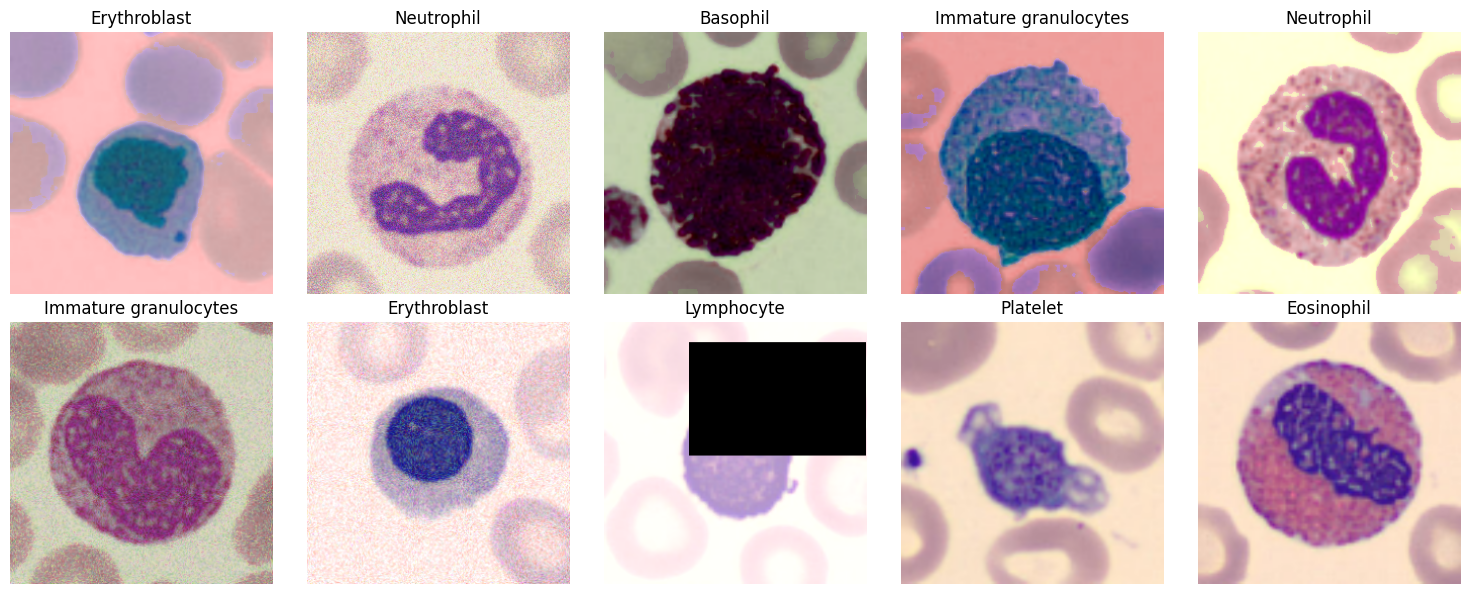

In [6]:
import matplotlib.pyplot as plt
from math import ceil

# Function to display images and their labels in multiple rows
def display_images(dataset, n_images, n_cols=5):
    n_rows = ceil(n_images / n_cols)
    plt.figure(figsize=(15, 3 * n_rows))

    dataset = dataset.unbatch()

    all_images = []
    all_labels = []
    
    for img, lbl in dataset:
        all_images.append(img.numpy())
        all_labels.append(lbl.numpy())
    
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    for i in range(len(all_images)):

        if n_images > batch_size:
            print(f"Il batch contiene solo {n_available} immagini. Mostrando quelle disponibili.")
            n_images = n_available

        for j in range(n_images):
            plt.subplot(n_rows, n_cols, j + 1)
            img = all_images[j].astype("uint8")
            plt.imshow(img)

            label_index = all_labels[j].argmax()
            label_name = labels[label_index]
            plt.title(label_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    
nprint = 10
display_images(images_dataset, nprint, n_cols=5)

# Transfer learning using a pre-trained model

In [7]:
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB4, DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

model_class = getattr(tf.keras.applications, trained_model + tm_version)

def build_model(
    input_shape=(target_size[0], target_size[1], 3),
    output_shape=8,
    learning_rate=learning_rate,
    l2_lambda=l2_lambda,
    dropout_rate=dropout_rate,
    seed=42,
    depth=None
):
    # Defining the right format for the input layer
    x = tf.keras.Input(shape=input_shape)
    
    # Load the pre-trained model but without the final layer (include_top = false)
    base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False

    # Extract features using GlobalAveragePooling instead of Flatten
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Dense Layer with Batch Normalization and Dropout
    x = Dense(units=initial_neurons,
              kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
              activation='relu',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    x = Dropout(dropout_rate)(x)
    
    # Output layer
    predictions = Dense(output_shape, activation='softmax')(x)  # Final layer with the 8 classes

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate, 
        decay_steps=1000, 
        decay_rate=0.90,
        staircase=True
    )

    # AdamW optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.00001)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Class for advanced metrics

In [8]:
class MetricsCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.precision_values = []
        self.recall_values = []
        self.f1_values = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = [], []
        for x, y in valid_dataset.unbatch():
            X_val.append(x.numpy())
            y_val.append(y.numpy())

        X_val = np.array(X_val)
        y_val = np.array(y_val)
        
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        y_true = np.argmax(y_val, axis=1)
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

        self.precision_values.append(precision)
        self.recall_values.append(recall)
        self.f1_values.append(f1)

# Training

In [9]:
tf.keras.backend.clear_session()

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

metrics_callback = MetricsCallback()

# Store the callback in a list
callbacks = [early_stopping, metrics_callback]

model_builders = {f"build_{model_class.__name__}_model": build_model}

base_model = model_builders[f"build_{model_class.__name__}_model"]()

# Display a summary of the model architecture
show_trainable = trained_model != 'ConvNeXtBase'
base_model.summary(expand_nested=True, show_trainable=show_trainable)

# Plot the model architecture
tfk.utils.plot_model(base_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

history = base_model.fit(
    train_dataset,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    callbacks = callbacks,
    class_weight = class_weights,
    validation_data = valid_dataset
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Validation accuracy: {final_val_accuracy}%')

base_model.save("base_model.keras")

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1     │ (None, 260,     │         0 │ -              │   -   │
│ (InputLayer)      │ 260, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 260,     │         0 │ input_layer_1… │   -   │
│ (Rescaling)       │ 260, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 260,     │         7 │ rescaling[0][… │   N   │
│ (Normalization)   │ 260, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_1       │ (None, 260,     │         0 │ normalization… │   -   │
│ (Rescaling)       │ 260, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv_pad     │ (None, 261,     │         0 │ rescaling_1[0… │   -   │
│ (ZeroPadding2D)   │ 261, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 130,     │       864 │ stem_conv_pad… │   N   │
│ (Conv2D)          │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 130,     │       128 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 130,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_dwconv    │ (None, 130,     │       288 │ stem_activati… │   N   │
│ (DepthwiseConv2D) │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_bn        │ (None, 130,     │       128 │ block1a_dwcon… │   N   │
│ (BatchNormalizat… │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_activati… │ (None, 130,     │         0 │ block1a_bn[0]… │   -   │
│ (Activation)      │ 130, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_squee… │ (None, 32)      │         0 │ block1a_activ… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_resha… │ (None, 1, 1,    │         0 │ block1a_se_sq… │   -   │
│ (Reshape)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_reduce │ (None, 1, 1, 8) │       264 │ block1a_se_re… │   N   │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_expand │ (None, 1, 1,    │       288 │ block1a_se_re… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_excite │ (None, 130,     │         0 │ block1a_activ… │   -   │
│ (Multiply)        │ 130, 32)        │           │ block1a_se_ex… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 130,     │       512 │ block1a_se_ex… │   N 

 Total params: 8,136,961 (31.04 MB)

 Trainable params: 365,576 (1.39 MB)

 Non-trainable params: 7,771,385 (29.65 MB)

Epoch 1/50


I0000 00:00:1732446251.254443      95 service.cc:145] XLA service 0x7a8d300048b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732446251.254531      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/538 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.1319 - loss: 4.1000   

I0000 00:00:1732446285.284208      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/stepp - accur
Epoch 1: Precision=0.7248, Recall=0.7055, F1=0.7006
538/538 ━━━━━━━━━━━━━━━━━━━━ 141s 173ms/step - accuracy: 0.2944 - loss: 3.1243 - val_accuracy: 0.7055 - val_loss: 1.3825
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/stepep - accurac
Epoch 2: Precision=0.8000, Recall=0.7714, F1=0.7728
538/538 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - accuracy: 0.5375 - loss: 1.9937 - val_accuracy: 0.7714 - val_loss: 1.1638
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/stepep - accurac
Epoch 3: Precision=0.8208, Recall=0.8083, F1=0.8056
538/538 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - accuracy: 0.6074 - loss: 1.7325 - val_accuracy: 0.8083 - val_loss: 1.0510
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/stepep - accurac
Epoch 4: Precision=0.8568, Recall=0.8426, F1=0.8430
538/538 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.6377 - loss: 1.5924 - val_accuracy: 0.8426 - val_loss: 0.9893
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/stepep - accurac
Epoch 5: Pr

# Plot the accuracy, loss and performance metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
                       precision    recall  f1-score   support

             Basophil       0.80      0.92      0.86       108
           Eosinophil       0.95      0.92      0.93       277
         Erythroblast       0.95      0.89      0.92       138
Immature granulocytes       0.90      0.80      0.85       254
           Lymphocyte       0.83      0.94      0.88       108
             Monocyte       0.81      0.86      0.83       126
           Neutrophil       0.93      0.97      0.95       297
             Platelet       0.99      0.98      0.99       210

             accuracy                           0.91      1518
            macro avg       0.89      0.91      0.90      1518
         weighted avg       0.91      0.91      0.91      1518

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9033 - loss: 0.7323
Test Loss: 0.7178207039833069
Test Accuracy: 0.9097496867179871
                       

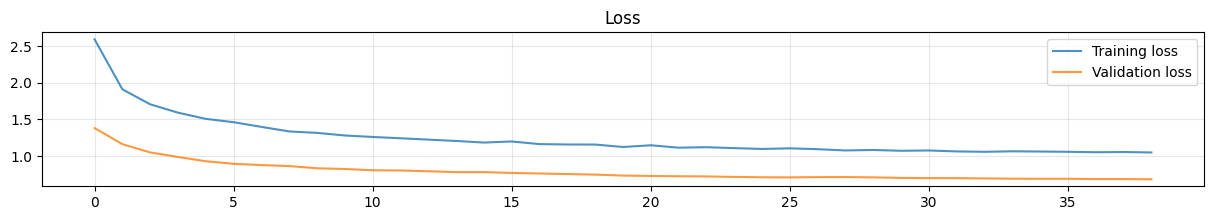

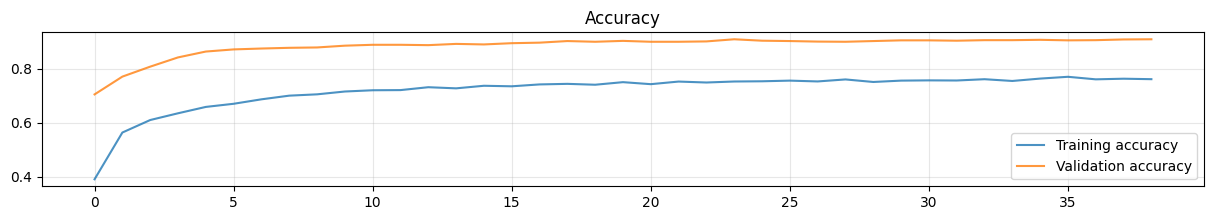

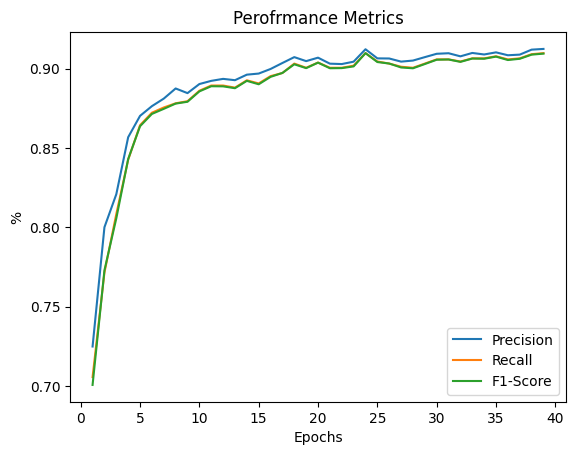

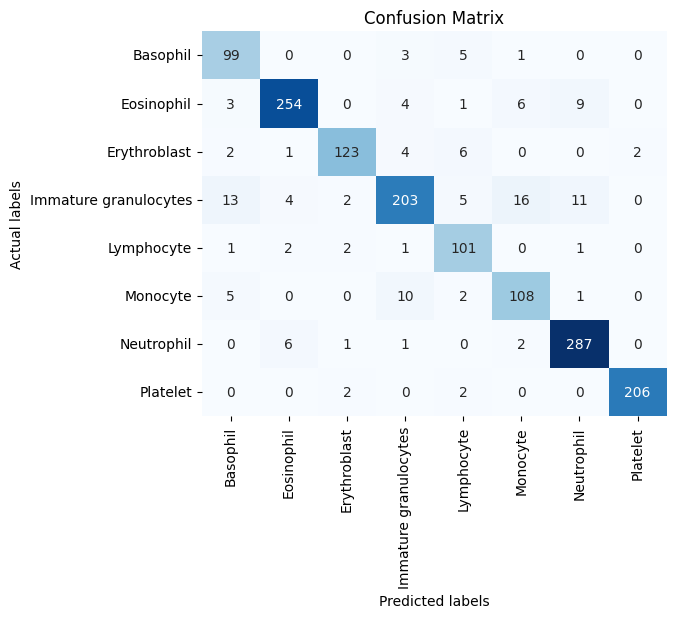

In [10]:
import seaborn as sns

labels_list = [label for _, label in sorted(labels.items())]

X_val, y_val = [], []
for x, y in valid_dataset.unbatch():
    X_val.append(x.numpy())
    y_val.append(y.numpy())

X_val = np.array(X_val)
y_val = np.array(y_val)

y_val_pred = np.argmax(base_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(classification_report(y_val_true, y_val_pred, target_names=labels_list))

X_test, y_test = [], []
for x, y in test_dataset.unbatch():
    X_test.append(x.numpy())
    y_test.append(y.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test_pred = np.argmax(base_model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)

test_loss, test_acc = base_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(classification_report(y_test_true, y_test_pred, target_names=labels_list))

del base_model

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

precision_val_values = np.array(metrics_callback.precision_values).flatten()
recall_val_values = np.array(metrics_callback.recall_values).flatten()
f1_val_values = np.array(metrics_callback.f1_values).flatten()

epochs = min(epochs, len(precision_val_values))
ar_epochs = np.arange(1, epochs + 1)

plt.plot(ar_epochs, precision_val_values, label='Precision')
plt.plot(ar_epochs, recall_val_values, label='Recall')
plt.plot(ar_epochs, f1_val_values, label='F1-Score')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title('Perofrmance Metrics')
plt.legend()

plt.show()

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=labels_list, 
            yticklabels=labels_list
           )

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

plt.show()

# Fine tuning

## Reload the model

In [11]:
fined_model = tfk.models.load_model("base_model.keras")

## Unfreeze some layers

In [12]:
for layer in fined_model.layers:
    layer.trainable = True

for layer in fined_model.layers[:-32]:
    layer.trainable = False

for i, layer in enumerate(fined_model.layers):
    if layer.trainable :
        print(i, layer.name, layer.trainable)

fined_model.summary()

314 block7a_activation True
315 block7a_se_squeeze True
316 block7a_se_reshape True
317 block7a_se_reduce True
318 block7a_se_expand True
319 block7a_se_excite True
320 block7a_project_conv True
321 block7a_project_bn True
322 block7b_expand_conv True
323 block7b_expand_bn True
324 block7b_expand_activation True
325 block7b_dwconv True
326 block7b_bn True
327 block7b_activation True
328 block7b_se_squeeze True
329 block7b_se_reshape True
330 block7b_se_reduce True
331 block7b_se_expand True
332 block7b_se_excite True
333 block7b_project_conv True
334 block7b_project_bn True
335 block7b_drop True
336 block7b_add True
337 top_conv True
338 top_bn True
339 top_activation True
340 global_average_pooling2d True
341 batch_normalization True
342 dropout True
343 dense True
344 dropout_1 True
345 dense_1 True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit

 Total params: 8,868,114 (33.83 MB)

 Trainable params: 3,324,020 (12.68 MB)

 Non-trainable params: 4,812,941 (18.36 MB)

 Optimizer params: 731,153 (2.79 MB)

## Second training

In [13]:
# Compile the model
fined_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate = learning_rate/10, weight_decay=0.0001), metrics=['accuracy'])

# Learning rate schedule
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=learning_rate/100
)

tfk.utils.plot_model(fined_model)

metrics_callback2 = MetricsCallback()

early_stopping2 = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience//2,
    restore_best_weights=True
)

callbacks2 = [early_stopping2, metrics_callback2, lr_scheduler]

epochs2 = epochs // 2

history = fined_model.fit(
    train_dataset,
    batch_size = batch_size,
    epochs = epochs2,
    validation_data = valid_dataset,
    class_weight = class_weights,
    callbacks=callbacks2
).history

fined_model.save("fined_model.keras")

Epoch 1/19
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/stepp - accur
Epoch 1: Precision=0.8945, Recall=0.8880, F1=0.8884
538/538 ━━━━━━━━━━━━━━━━━━━━ 139s 162ms/step - accuracy: 0.6857 - loss: 1.3134 - val_accuracy: 0.8880 - val_loss: 0.7542 - learning_rate: 1.0000e-05
Epoch 2/19
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/stepep - accurac
Epoch 2: Precision=0.9031, Recall=0.8972, F1=0.8973
538/538 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.7238 - loss: 1.1752 - val_accuracy: 0.8972 - val_loss: 0.7239 - learning_rate: 1.0000e-05
Epoch 3/19
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/stepep - accura
Epoch 3: Precision=0.9070, Recall=0.9012, F1=0.9012
538/538 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.7507 - loss: 1.1027 - val_accuracy: 0.9012 - val_loss: 0.7028 - learning_rate: 1.0000e-05
Epoch 4/19
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/stepep - accurac
Epoch 4: Precision=0.9115, Recall=0.9051, F1=0.9051
538/538 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.7582 - loss: 1.0927 - val_accuracy: 0.9051

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
                       precision    recall  f1-score   support

             Basophil       0.84      0.97      0.90       108
           Eosinophil       0.98      0.96      0.97       277
         Erythroblast       0.98      0.89      0.94       138
Immature granulocytes       0.94      0.79      0.86       254
           Lymphocyte       0.88      0.97      0.92       108
             Monocyte       0.79      0.93      0.85       126
           Neutrophil       0.95      0.96      0.95       297
             Platelet       0.98      1.00      0.99       210

             accuracy                           0.93      1518
            macro avg       0.92      0.93      0.92      1518
         weighted avg       0.93      0.93      0.93      1518

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9261 - loss: 0.5820
Test Loss: 0.577838659286499
Test Accuracy: 0.9295125007629395
                       p

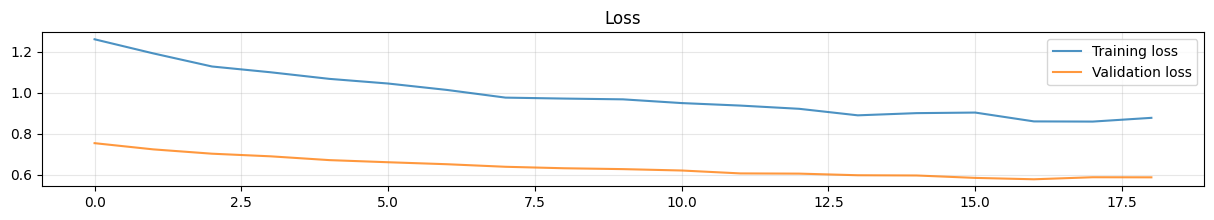

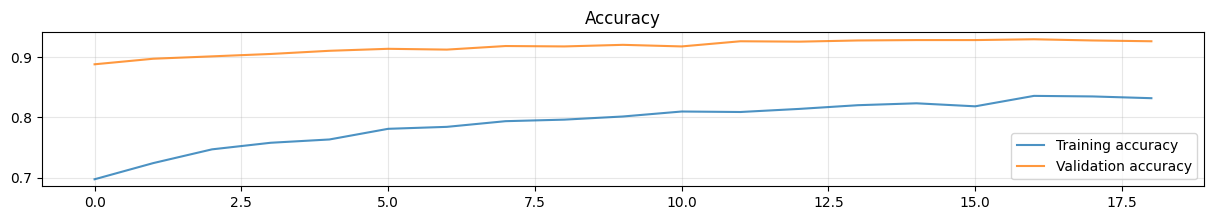

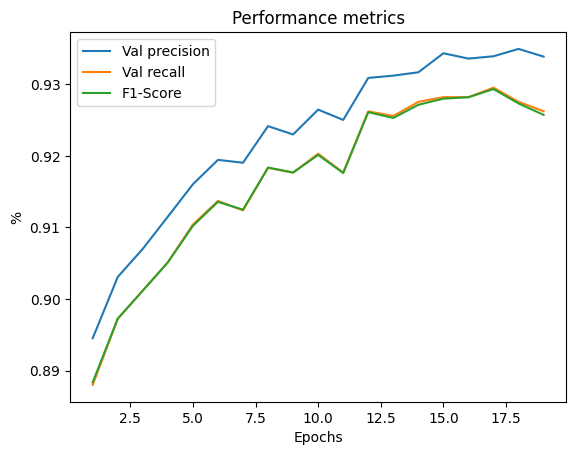

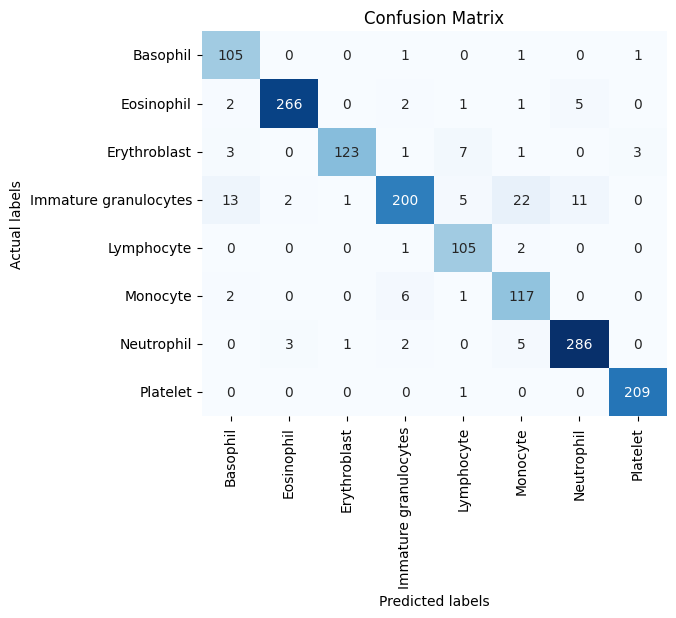

In [14]:
labels_list = [label for _, label in sorted(labels.items())]

X_val, y_val = [], []
for x, y in valid_dataset.unbatch():
    X_val.append(x.numpy())
    y_val.append(y.numpy())

X_val = np.array(X_val)
y_val = np.array(y_val)

y_val_pred = np.argmax(fined_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(classification_report(y_val_true, y_val_pred, target_names=labels_list))

X_test, y_test = [], []
for x, y in test_dataset.unbatch():
    X_test.append(x.numpy())
    y_test.append(y.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test_pred = np.argmax(fined_model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)

test_loss, test_acc = fined_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(classification_report(y_test_true, y_test_pred, target_names=labels_list))

del fined_model

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

precision_val_values = np.array(metrics_callback2.precision_values).flatten()
recall_val_values = np.array(metrics_callback2.recall_values).flatten()
f1_val_values = np.array(metrics_callback2.f1_values).flatten()

epochs2 = min(epochs2, len(precision_val_values))
ar_epochs = np.arange(1, epochs2 + 1)

plt.plot(ar_epochs, precision_val_values, label='Val precision')
plt.plot(ar_epochs, recall_val_values, label='Val recall')
plt.plot(ar_epochs, f1_val_values, label='F1-Score')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title('Performance metrics')
plt.legend()

plt.show()

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=labels_list, 
            yticklabels=labels_list
           )

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')

plt.show()

# Python script for testing 

In [15]:
%%writefile model.py

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
preprocess_input = tfk.applications.efficientnet.preprocess_input

# The target size for the input images (it changes wrt the pre-trained model used)
size = (260, 260)

class Model:

    # Constructor
    def __init__(self):
        # Load the trained model
        self.neural_network = tfk.models.load_model("fined_model2.keras")

    def tta_augmentations(self):
        # Define augmentations for test-time augmentation
        augmentations = [
            lambda x: x,  # Original images
            lambda x: tf.image.flip_left_right(x),
            lambda x: tf.image.flip_up_down(x),
            lambda x: tf.image.rot90(x, k=1),
            lambda x: tf.image.random_brightness(x, max_delta=0.2),
        ]
        return augmentations

    # Elaborate the pre-processing using batches to optimize the GPU memory
    def data_generator(self, data, batch_size, augmentations=None):

        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]

            batch = tf.image.resize(tf.convert_to_tensor(batch, dtype=tf.float32), size)

            if augmentations:
                augmented_batches = []
                # Apply augmentations to each image in the batch and create 5 modified versions per image
                for img in batch:
                    augmented_img = [aug(img) for aug in augmentations]
                    augmented_batches.extend(augmented_img)
                # Combine the original and augmented images into one batch (5 times the original size)
                batch = tf.stack(augmented_batches)

            yield (preprocess_input(batch),)

    def predict(self, X, batch_size=8, tta=True):

        augmentations = self.tta_augmentations() if tta else None

        preds = self.neural_network.predict(
            self.data_generator(data=X, batch_size=batch_size, augmentations=augmentations),
            verbose=1
        )

        # If there are augmentations, average the predictions
        if tta and augmentations:
            num = len(X)

            preds = preds.reshape(num, len(augmentations), -1)
            preds = np.mean(preds, axis=1)

        # Convert from one-hot encoding to predicted class labels
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


# Saving the model

In [16]:
import zipfile
import model

# Print the list of files in the output directory
print(f"List of output files: {os.listdir('/kaggle/working/')}")

# Check that the images size is correct
assert target_size == model.size

# Create the name of the ZIP
filename = f'{trained_model + tm_version}_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the ZIP
with zipfile.ZipFile(filename, 'w') as zipf:
    zipf.write('model.py')
    zipf.write('fined_model.keras')

print(f"\nFile {filename} created successfully!")

List of output files: ['fined_model.keras', '.virtual_documents', '__pycache__', 'base_model.keras', 'model.png', 'model.py']

File EfficientNetB2_241124_114241.zip created successfully!
